In [59]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import pmdarima as pm

In [2]:
from tensorflow.keras.models import load_model

# Model LTSM

In [3]:
df = pd.read_csv('D:/thuantt2/Document/Big_data_project/data/gold_data.csv')
df.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume
0,8/30/2000,GC=F,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,8/31/2000,GC=F,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,9/1/2000,GC=F,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,9/5/2000,GC=F,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,9/6/2000,GC=F,274.200012,274.200012,274.200012,274.200012,274.200012,0


In [4]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,8/30/2000,273.899994
1,8/31/2000,278.299988
2,9/1/2000,277.000000
3,9/5/2000,275.799988
4,9/6/2000,274.200012


In [5]:
df.Date.dtype

dtype('O')

In [6]:
df.Date = df.Date.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [7]:
df.Date.dtype

dtype('<M8[ns]')

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012
...,...
2024-08-27,2516.000000
2024-08-28,2501.000000
2024-08-29,2525.699951


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[["Close"]])

In [15]:
len(scaled_data)

6024

In [45]:
scaled_data

array([[0.00826482],
       [0.01019914],
       [0.00962764],
       ...,
       [0.99819752],
       [0.98417374],
       [1.        ]])

In [18]:
# scaled_data[i-100:i]

In [19]:
scaled_data[100]

array([0.00413241])

In [20]:
x_data = []
y_data = []

for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])
x_data, y_data = np.array(x_data), np.array(y_data)

In [27]:
int(len(x_data))

5924

In [11]:
splitting_len = int(len(x_data)*0.8)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [30]:
len(x_train)

4739

In [31]:
len(x_test)

1185

In [36]:
x_train.shape

(4739, 100, 1)

In [47]:
# define model
model = Sequential([layers.Input((100, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [48]:
# fit model
model.fit(x_train, y_train, batch_size = x_train.shape[1], epochs = 2)

Epoch 1/2
48/48 [==============================] - 12s 131ms/step - loss: 0.0181 - mean_absolute_error: 0.0850
Epoch 2/2
48/48 [==============================] - 6s 120ms/step - loss: 1.9523e-04 - mean_absolute_error: 0.0104


In [51]:
model.save('D:/thuantt2/Document/Big_data_project/model/my_model.h5', overwrite=True)

In [52]:
model=load_model('D:/thuantt2/Document/Big_data_project/model/my_model.h5')

In [53]:
model.predict(x_test)

38/38 [==============================] - 2s 29ms/step


array([[0.53208965],
       [0.53221786],
       [0.5325202 ],
       ...,
       [0.8959967 ],
       [0.89760137],
       [0.89818984]], dtype=float32)

# Model ARIMA

In [54]:
r_t = np.log(df['Close']/df['Close'].shift(1))
mean = np.nanmean(r_t)

In [56]:
scaled_data = df[["Close"]]
scaled_data = scaled_data.fillna(0).to_numpy()
len(scaled_data)

6024

In [57]:
splitting_len = int(len(scaled_data)*0.8)
y_train = scaled_data[:splitting_len]
y_test = scaled_data[splitting_len:]

C:\Users\LAP13398-local\anaconda3\envs\thuantran\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


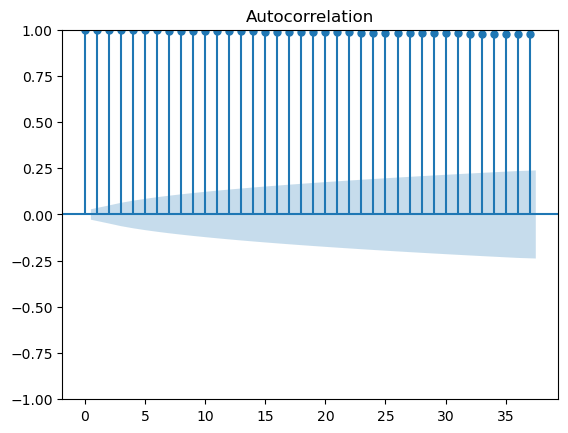

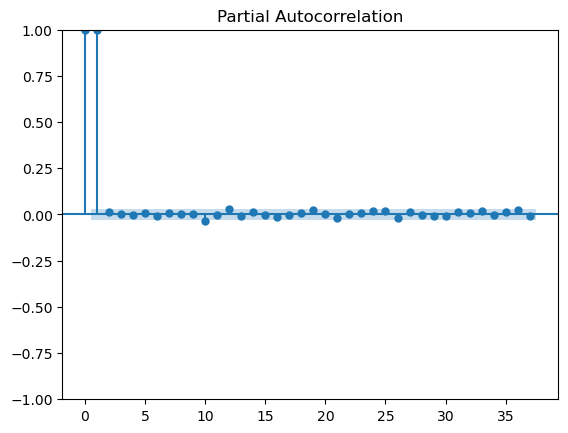

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(y_train)
pacf_original = plot_pacf(y_train)

In [60]:
# Fit your model
model1 = pm.auto_arima(y_train, stepwise=False, seasonal=False)